In [17]:
import keras
from keras.applications import ResNet50
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Concatenate
from keras.models import Model

In [18]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [19]:

def unet_with_resnet50(input_shape=(256, 256, 3)):
    # Load ResNet50 pretrained weights, excluding the top layers
    resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Encoder: Extract features from ResNet50
    encoder_outputs = [
        resnet50.get_layer("conv1_relu").output,  # Stage 1
        resnet50.get_layer("conv2_block3_out").output,  # Stage 2
        resnet50.get_layer("conv3_block4_out").output,  # Stage 3
        resnet50.get_layer("conv4_block6_out").output,  # Stage 4
        resnet50.get_layer("conv5_block3_out").output,  # Stage 5
    ]

    # Decoder: Create U-Net decoder using transpose convolutions or upsampling
    def decoder_block(input_tensor, skip_tensor, num_filters):
        x = Conv2DTranspose(num_filters, (3, 3), strides=2, padding="same")(input_tensor)
        x = Concatenate()([x, skip_tensor])
        x = Conv2D(num_filters, (3, 3), activation="relu", padding="same")(x)
        x = Conv2D(num_filters, (3, 3), activation="relu", padding="same")(x)
        return x

    # Decoder steps
    x = encoder_outputs[-1]  # Start from the bottleneck
    x = decoder_block(x, encoder_outputs[-2], 512)
    x = decoder_block(x, encoder_outputs[-3], 256)
    x = decoder_block(x, encoder_outputs[-4], 128)
    x = decoder_block(x, encoder_outputs[-5], 64)

    # Final layer
    outputs = Conv2D(1, (1, 1), activation="sigmoid")(x)

    # Create the U-Net model
    model = Model(inputs=resnet50.input, outputs=outputs)

    return model

# Example usage
model = unet_with_resnet50(input_shape=(256, 256, 3))


In [20]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

class UNetResNet50(nn.Module):
    def __init__(self, pretrained=True):
        super(UNetResNet50, self).__init__()
        resnet = resnet50(pretrained=pretrained)

        # Extract ResNet encoder layers
        self.encoder1 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
        self.encoder2 = resnet.layer1
        self.encoder3 = resnet.layer2
        self.encoder4 = resnet.layer3
        self.encoder5 = resnet.layer4

        # Decoder layers
        self.decoder4 = self._decoder_block(2048, 1024)
        self.decoder3 = self._decoder_block(1024, 512)
        self.decoder2 = self._decoder_block(512, 256)
        self.decoder1 = self._decoder_block(256, 64)

        # Final output layer
        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def _decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)
        enc4 = self.encoder4(enc3)
        enc5 = self.encoder5(enc4)

        # Decoder
        dec4 = self.decoder4(enc5) + enc4
        dec3 = self.decoder3(dec4) + enc3
        dec2 = self.decoder2(dec3) + enc2
        dec1 = self.decoder1(dec2) + enc1

        # Final output
        out = self.final(dec1)
        return torch.sigmoid(out)

# Example usage
model = UNetResNet50(pretrained=True)
print(model)


c:\Program Files\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Program Files\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


UNetResNet50(
  (encoder1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (encoder2): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, 

In [23]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.optimizers import Adam
import random

# Set image dimensions and batch size
IMG_HEIGHT, IMG_WIDTH = 256, 256
BATCH_SIZE = 8

# Paths
DATASET_DIR = "D:/FinalYearProject/Datasets/Wenchuan"  # Replace with the path to your dataset folder
IMG_DIR = os.path.join(DATASET_DIR, "img")
MASK_DIR = os.path.join(DATASET_DIR, "mask")


# Helper function to load images and masks
def load_data(img_dir, mask_dir):
    img_paths = sorted(
        [os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith(".tif")]
    )
    mask_paths = sorted(
        [os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith(".TIF")]
    )

    images = [
        img_to_array(load_img(img, target_size=(IMG_HEIGHT, IMG_WIDTH))) / 255.0
        for img in img_paths
    ]
    masks = [
        img_to_array(
            load_img(mask, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode="grayscale")
        )
        / 255.0
        for mask in mask_paths
    ]

    return np.array(images), np.array(masks)


# Load images and masks
images, masks = load_data(IMG_DIR, MASK_DIR)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    images, masks, test_size=0.2, random_state=42
)

# Print dataset information
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")


# Define a U-Net model
def build_unet(input_shape):
    inputs = tf.keras.layers.Input(input_shape)

    # Encoder
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same")(p1)
    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same")(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(256, (3, 3), activation="relu", padding="same")(p2)
    c3 = tf.keras.layers.Conv2D(256, (3, 3), activation="relu", padding="same")(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(512, (3, 3), activation="relu", padding="same")(p3)
    c4 = tf.keras.layers.Conv2D(512, (3, 3), activation="relu", padding="same")(c4)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = tf.keras.layers.Conv2D(1024, (3, 3), activation="relu", padding="same")(p4)
    c5 = tf.keras.layers.Conv2D(1024, (3, 3), activation="relu", padding="same")(c5)

    # Decoder
    u6 = tf.keras.layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding="same")(
        c5
    )
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(512, (3, 3), activation="relu", padding="same")(u6)
    c6 = tf.keras.layers.Conv2D(512, (3, 3), activation="relu", padding="same")(c6)

    u7 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")(
        c6
    )
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(256, (3, 3), activation="relu", padding="same")(u7)
    c7 = tf.keras.layers.Conv2D(256, (3, 3), activation="relu", padding="same")(c7)

    u8 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(
        c7
    )
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same")(u8)
    c8 = tf.keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same")(c8)

    u9 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    c9 = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same")(u9)
    c9 = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation="sigmoid")(c9)

    model = tf.keras.models.Model(inputs=[inputs], outputs=[outputs])
    return model


# Build the U-Net model
model = build_unet((IMG_HEIGHT, IMG_WIDTH, 3))
model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss="binary_crossentropy",
    metrics=["accuracy", MeanIoU(num_classes=2)],
)

# Train the model
history = model.fit(
    X_train, y_train, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, epochs=2
)

# Evaluate the model
val_loss, val_accuracy, val_iou = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Mean IoU: {val_iou}")

Training samples: 142
Validation samples: 36
Epoch 1/2


c:\Program Files\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1197']. Received: the structure of inputs=*
  warnings.warn(


18/18 ━━━━━━━━━━━━━━━━━━━━ 245s 13s/step - accuracy: 0.9532 - loss: 18402742.0000 - mean_io_u_3: 0.6837 - val_accuracy: 0.9511 - val_loss: 0.7462 - val_mean_io_u_3: 0.5000
Epoch 2/2
18/18 ━━━━━━━━━━━━━━━━━━━━ 237s 13s/step - accuracy: 0.9544 - loss: 0.8664 - mean_io_u_3: 0.5000 - val_accuracy: 0.9511 - val_loss: 0.5525 - val_mean_io_u_3: 1.0000
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.9504 - loss: 0.5525 - mean_io_u_3: 1.0000
Validation Loss: 0.5525097250938416
Validation Accuracy: 0.9510905146598816
Validation Mean IoU: 0.9999998807907104


(1, 256, 256, 3)
Model expects input shape: (None, 256, 256, 3)
Single image shape after preprocessing: (1, 256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step
Predicted mask shape: (1, 256, 256, 1)


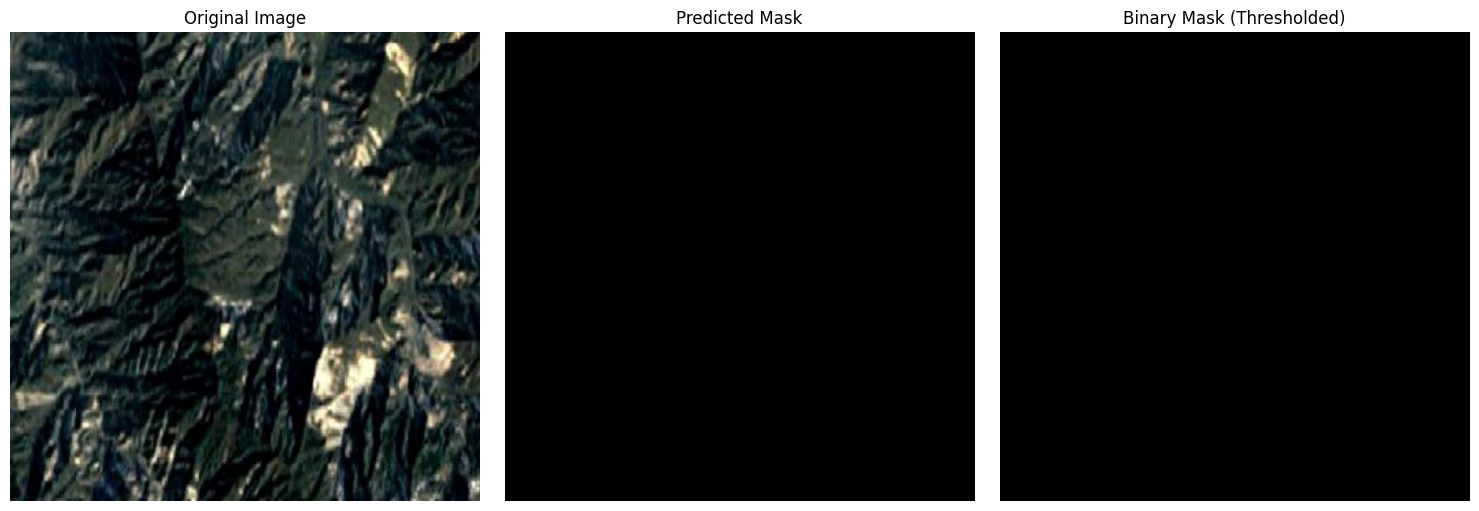

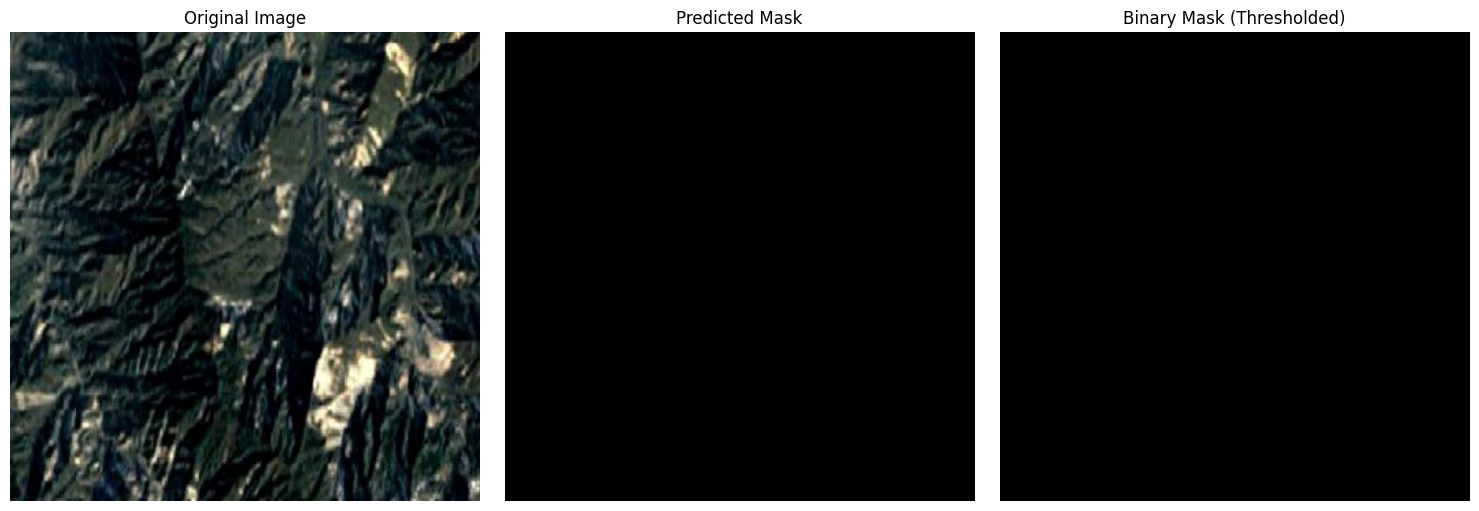

In [24]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Path to the single test image
SINGLE_TEST_IMAGE_PATH = "D:/FinalYearProject/Datasets/Wenchuan/img/wenchuan027.tif"  # Replace with your image file path

# Function to load and preprocess a single image
def preprocess_image(image_path, target_size):
    # Load the image and resize it
    image = load_img(image_path, target_size=target_size)
    # Convert the image to an array and normalize it
    image_array = img_to_array(image) / 255.0
    # Add a batch dimension (required by the model)
    image_array = np.expand_dims(image_array, axis=0)
    return image_array

# Load and preprocess the single test image
single_image = preprocess_image(SINGLE_TEST_IMAGE_PATH, (IMG_HEIGHT, IMG_WIDTH))
print(single_image.shape)  # Should output (1, IMG_HEIGHT, IMG_WIDTH, 3)

# Debugging: Check model input shape
print("Model expects input shape:", model.input_shape)

# Load and preprocess the image
single_image = preprocess_image(SINGLE_TEST_IMAGE_PATH, (IMG_HEIGHT, IMG_WIDTH))

# Debugging: Check single image shape
print("Single image shape after preprocessing:", single_image.shape)

# Predict the mask
predicted_mask = model.predict(single_image)

# Debugging: Check predicted mask shape
print("Predicted mask shape:", predicted_mask.shape)

# Threshold the predicted mask
binary_mask = (predicted_mask[0] > 0.5).astype(np.uint8)

# Visualize the prediction
visualize_single_prediction(SINGLE_TEST_IMAGE_PATH, predicted_mask, binary_mask)


# Visualize the results
def visualize_single_prediction(image_path, predicted_mask, binary_mask):
    # Load the original image for visualization
    original_image = load_img(image_path)
    
    # Plot the original image, predicted mask, and binary mask
    plt.figure(figsize=(15, 5))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    # Predicted mask
    plt.subplot(1, 3, 2)
    plt.imshow(predicted_mask.squeeze(), cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    # Binary mask
    plt.subplot(1, 3, 3)
    plt.imshow(binary_mask.squeeze(), cmap="gray")
    plt.title("Binary Mask (Thresholded)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Visualize the prediction for the single image
visualize_single_prediction(SINGLE_TEST_IMAGE_PATH, predicted_mask, binary_mask)